In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BONUS_THRESH = 4_000

START_BALANCE = 10896.91

FINAL_MONTH, FINAL_DAY = 7, 31
LAST_YEAR = 2024

In [3]:
credit_dfs = [pd.read_csv(f"data/chase/{path}") for path in os.listdir("data/chase/") if path.startswith("Chase3098")]
credit_df = pd.concat(credit_dfs).reset_index()
credit_df = credit_df.drop("Transaction Date", axis="columns")
credit_df = credit_df.rename({"Post Date": "Posting Date"}, axis="columns")
credit_df["Posting Date"] = pd.to_datetime(credit_df["Posting Date"])

checking_df = pd.read_csv("data\chase\Chase7113_Activity_20240817.CSV", index_col=False)
checking_df = checking_df[checking_df["Type"] != "MISC_DEBIT"]
checking_df["Balance"] = checking_df.Balance.astype(np.float64)
checking_df["Posting Date"] = pd.to_datetime(checking_df["Posting Date"])
checking_df = checking_df.sort_values("Posting Date")

# Start from Sept 2022 (first stable post-moving month)
credit_df = credit_df[credit_df["Posting Date"] >= datetime.datetime(day=1, month=9, year=2022)]
checking_df = checking_df[checking_df["Posting Date"] >= datetime.datetime(day=1, month=9, year=2022)]

# End at last month
credit_df = credit_df[credit_df["Posting Date"] <= datetime.datetime(day=FINAL_DAY, month=FINAL_MONTH, year=LAST_YEAR)]
checking_df = checking_df[
    checking_df["Posting Date"] <= datetime.datetime(day=FINAL_DAY, month=FINAL_MONTH, year=LAST_YEAR)
]

# Add month col for grouping
credit_df["month"] = pd.to_datetime(
    credit_df["Posting Date"].dt.year.astype(str) + "-" + credit_df["Posting Date"].dt.month.astype(str)
)
checking_df["month"] = pd.to_datetime(
    checking_df["Posting Date"].dt.year.astype(str) + "-" + checking_df["Posting Date"].dt.month.astype(str)
)

### 1. Prep debit expenses table

In [4]:
debit_df = checking_df[checking_df.Amount < 0]

# ignore credit card payments, since they double count cc expenses
cc_pay_keywords = ["Payment to Chase card", "CHASE CREDIT CRD"]
debit_df = debit_df[~pd.DataFrame([debit_df.Description.str.contains(kw) for kw in cc_pay_keywords]).any(axis=0)]

### 2. Prep credit expenses table

In [5]:
# drop cc payments
cc_pay_keywords = ["Returned Payment", "Payment Thank You", "AUTOMATIC PAYMENT - THANK"]
credit_df = credit_df[~pd.DataFrame([credit_df.Description.str.contains(kw) for kw in cc_pay_keywords]).any(axis=0)]

### 3. Prep income table

In [6]:
credit_df[credit_df.Amount > 0]

,index,Posting Date,Description,Category,Type,Amount,Memo,month
77,77,2022-11-22,UNITED 0162447982370,Travel,Return,170.00,NaN,2022-11-01
221,51,2023-12-05,Ralph Lauren Corporation,Shopping,Return,72.00,NaN,2023-12-01
271,101,2023-11-15,USTA.COM,Entertainment,Return,28.45,NaN,2023-11-01
308,138,2023-10-22,Zipcar Trip OCT21,Travel,Return,37.72,NaN,2023-10-01
315,145,2023-10-22,Zipcar Trip OCT21,Travel,Return,10.62,NaN,2023-10-01
330,160,2023-10-15,JETBLUE 2790499942499,Travel,Return,213.90,NaN,2023-10-01
437,267,2023-09-22,7462-RailNinja,Travel,Return,306.00,NaN,2023-09-01
498,328,2023-09-06,7462-RailNinja,Travel,Return,360.00,NaN,2023-09-01
541,371,2023-08-27,AMTRAK .COM 2320641598040,Travel,Return,51.00,NaN,2023-08-01
583,413,2023-08-09,AIRBNB * HMC3BSE2KD,Travel,Return,176.92,NaN,2023-08-01


In [7]:
income_df = checking_df[checking_df.Amount > 0]

# partition out paychecks
paycheck_df = income_df[income_df.Description.str.contains("MICROSOFT")]
income_df = income_df.drop(paycheck_df.index, axis=0)

# separate bonuses from paychecks
bonus_rows = []
for i, (idx, row) in enumerate(paycheck_df.iterrows()):
    if row.Amount > 4_000:
        # get bonus amount by comparing to surrounding paychecks
        if (i + 1 < len(paycheck_df)) and paycheck_df.iloc[i + 1].Amount > 2000:
            bonus_amt = row.Amount - paycheck_df.iloc[i + 1].Amount
        elif i != 0 and paycheck_df.iloc[i - 1].Amount > 2000:
            bonus_amt = row.Amount - paycheck_df.iloc[i - 1].Amount
        else:
            raise Exception("no valid paycheck to compare")

        # update paycheck_df
        paycheck_df.loc[idx, "Amount"] -= bonus_amt

        bonus_row = row.copy()
        row.Amount = bonus_amt

        # save bonus row
        bonus_rows.append(row)
bonus_df = pd.DataFrame(bonus_rows)

# partition out stocks (+ other random bonus looking things)
stock_keywords = ["SCHWAB", "NORTH LANE", "REAL TIME TRANSFER", "Morgan", "IRS", "COMM.", "FID"]
stock_df = income_df[pd.DataFrame([income_df.Description.str.contains(kw) for kw in stock_keywords]).any(axis=0)]

# remaining things are refunds related to specific expenses
refund_df = income_df.drop(stock_df.index)

# income line items
income_dfs = [paycheck_df, bonus_df, stock_df, refund_df]

del income_df

## Cash flow

TODO: identify rent, paychecks, cc payment

## Net worth over time

In [8]:
# debit_df + credit_df - refund_df
expense_df = pd.concat([debit_df, credit_df]).reset_index()

nontypical_expense_keywords = ["SCHWAB", "TAXPY"]
expense_df_nontypical = expense_df[
    pd.DataFrame([expense_df.Description.str.contains(kw) for kw in nontypical_expense_keywords]).any(axis=0)
]
expense_df_typical = expense_df.drop(expense_df_nontypical.index)

In [9]:
net_df = pd.concat([expense_df] + income_dfs).sort_values("Posting Date")

In [10]:
expense_df_typical_monthly = -expense_df_typical.groupby("month").Amount.sum()
expense_df_nontypical_monthly = -expense_df_nontypical.groupby("month").Amount.sum()
expense_df_monthly = -expense_df.groupby("month").Amount.sum()

In [90]:
cat_instructions = """1. Bills
2. Grocery
3. Necessary meals
4. Social food/drinks
5. Transit
6. Travel
7. Entertainment
8. Venmo
9. Shopping
10. Clothing
11. Haircut
12. Medical
13. Exercise
14. Medication
15. Subscriptions
16. Investments"""
rules = {
    "Bills": ["bozzuto", "eversource", "xfinity", "comcast", "lpcresi"],
    "Grocery": ["brothers", "wholef"],
    "Necessary meals": ["chipotle", "aceituna", "uber   eats", "doordash", "subway", "oxxo", "bon me", "tatte", "cava", "postmat", "mcdona", "instacar", "dunkin", "chowbus"],
    "Social food/drinks": ["zuma", "bar taco", "conces", "cask 'n", "shy bird", "harp", "phoenix", "flat top", "cheeky"],
    "Transit": ["mta", "mbta", "uber   trip", "lime", "bluebike", "beam", "uber *trip", "lim*ride", "bixi"],
    "Travel": ["airbnb", "united", "amtrak", "delta"],
    "Entertainment": ["ticketmaster", "gametime", "stubhub", "tickpick", "lucky strike", "golf", "seatgeek", " ski", "ski "],
    "Venmo": ["venmo"],
    "Shopping": ["amazon", "target", "amzn"],
    "Clothing": [],
    "Haircut": [],
    "Medical": ["colleen", "willems", "bspt", "dds"],
    "Exercise": ["usta", "volo"],
    "Medication": ["pharmacy"],
    "Subscriptions": ["zipcar", "mlb.tv"],
    "Investments": ["schwab"]
}
rules_map = {}
for cat, vals in rules.items():
    for val in vals:
        rules_map[val] = cat
num_map = [cat for cat in rules.keys()]

for i in range(len(expense_df)):
    # expense_df.iloc[i, expense_df.columns.get_loc("Category")] = None
    if expense_df.iloc[i, expense_df.columns.get_loc("Category")] is not None:
        continue
    for key in rules_map.keys():
        if key in expense_df.iloc[i]["Description"].lower():
            expense_df.iloc[i, expense_df.columns.get_loc("Category")] = rules_map[key]
            break
    print(expense_df.iloc[i, expense_df.columns.get_loc("Description")], expense_df.iloc[i, expense_df.columns.get_loc("Category")])

BIXI MONTREAL Transit
BIXI MONTREAL Transit
UBER CANADA/UBERTRIP None
BOUTIQUE HORS TAXES PH None
NEW CITY GAS None
BIXI MONTREAL Transit
BIXI MONTREAL Transit
STM BONAVENTURE DIN101 None
LIBRAIRIE PULP BOOKS &amp; None
BOSSA PR T- -MANGER None
PHARMAPRIX #1800 None
CAFE LILI &amp; OLI None
STM BONAVENTURE DIS101 None
CAFE LILI &amp; OLI None
JEAN COUTU  008 None
EPICERIE MOSAIQUE None
MR DUMPLING None
BARBOSSA None
BARBOSSA None
BLUEBOY YOGURT GLACE AND None
HUNGRYPANDA US INC None
SQ *BLUE DOG MOTEL None
KILO FRIPE VINTAGE None
CHEZ SCHWARTZ'S A COTE None
ASL MONTREAL None
TST* TRILLIUM BREWING COM None
Donate *BeringPrideRunFun None
LANSDOWNE PUB BOSTON None
SQ *MATCHA CAFE MAIKO BOS None
MADRAS DOSA CO None
SPOTHERO 844-356-8054 None
BOAT CRUISE SUMMER S None
NEWCITYGAS* NEWCITYGAS None
DUMPLING H* DUMPLING H None
STAR MARKET 3580 None
BOSTON CALLING MUSIC F None
TST* BUTTERMILK AND BOURB None
TST* FELIPES TAQUERIA None
BOSTON CALLING MUSIC F None
BOSTON CALLING MUSIC F None
TST* F

In [66]:
print("Left:", expense_df["Category"].isna().sum())
print(expense_df["Description"][expense_df["Category"].isna()].tolist())

Left: 746
['SNOOZE CLEARLAKE', 'AMC ONLINE 9640', 'SHARETEA RICE VILLAGE', 'PP*MUKU', '1010 CAFFE NERO CENTRAL S', 'TST* Los Tacos No.1 - TIM', 'PRUDENTIAL CTR MDSE', 'TIGER SUGAR', 'SNACK* EMPANADA MAMA (', 'SQ *FAY DA BAKERY', 'SQ *MAE ASIAN EATERY', 'PUTTSHACK BOSTON SEA.', 'TST* SALTY PIG', 'GO FRUIT LLC', "SCHOLAR'S", 'TST* Cloud and Spirits', 'BOSTON PAINTBALL INC', 'SP CRZYTEES', 'RUSSELL ORCHARDS', 'CHOWBUS', 'TST* Boston Burger Compan', 'TST* WHICH WICH - IHA - T', 'UA INFLT    0169803213854', 'TIGER NOODLE HOUSE', 'WESTIN HOU DWTN RESTW', 'HOPDODDY - RICE VILLAGE', 'BAYOU CITY RESALE  LLC', 'PLAT PARKING-LOT 555', 'SHARETEA RICE VILLAGE', 'PAR*FOGO HOUSTON', 'PLAT PARKING LOT 532', 'SQ *CIDERCADE HOUSTON', 'TST* Katzs - Montrose', 'EXPRESS#0161', 'UA INFLT    0169801524920', "KELLY'S ROAST BEEF BOS", 'TST* Hunsa Thai Kitchen -', 'ANNUAL MEMBERSHIP FEE', 'TST* SWEET PARIS - BAYBRO', 'OTSUKA RAMEN &amp; BAR', "WENDY'S 3936", 'SLOPESIDE GRILL', 'FOUR POINTS LODGE', 'Ralph Lauren

In [98]:
from IPython.display import clear_output
print("Left:", expense_df["Category"].isna().sum())
for i in range(len(expense_df)):
    if expense_df.iloc[i, expense_df.columns.get_loc("Category")] is None:
        print(expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")], expense_df.iloc[i, expense_df.columns.get_loc("Description")], expense_df.iloc[i, expense_df.columns.get_loc("Amount")])
        print(cat_instructions)
        try:
            cat_idx = int(input()) - 1 # zero index!
        except:
            clear_output()
            print(expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")], expense_df.iloc[i, expense_df.columns.get_loc("Description")], expense_df.iloc[i, expense_df.columns.get_loc("Amount")])
            print(cat_instructions)
            try:
                cat_idx = int(input()) - 1 # zero index!
            except:
                clear_output()
                print(expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")], expense_df.iloc[i, expense_df.columns.get_loc("Description")], expense_df.iloc[i, expense_df.columns.get_loc("Amount")])
                print(cat_instructions)
                cat_idx = int(input()) - 1 # zero index!
        clear_output()
        expense_df.iloc[i, expense_df.columns.get_loc("Category")] = num_map[cat_idx]

Left: 0


In [99]:
expense_df.to_csv("expense.csv")

In [ ]:
with pd.option_context("display.max_rows", 2301):
    display(expense_df_typical)

In [101]:
net_worth_df = pd.DataFrame(
    [df.groupby("month").Amount.sum() for df in income_dfs],
    index=["Paycheck", "Bonus", "Stock/Tax Return", "Misc/Refund"],
).T

net_worth_df["Typical Expenses"] = -expense_df_typical_monthly
net_worth_df["Atypical Expenses"] = -expense_df_nontypical_monthly
net_worth_df = net_worth_df.fillna(0)

In [102]:
net_worth_df

,Paycheck,Bonus,Stock/Tax Return,Misc/Refund,Typical Expenses,Atypical Expenses
month,,,,,,
2022-09-01,5920.82,0.00,728.68,35.75,-10021.96,0.0
2022-10-01,5668.49,0.00,0.00,585.11,-6463.45,0.0
2022-11-01,5668.52,0.00,0.00,2311.96,-8376.50,0.0
2022-12-01,5668.50,0.00,0.00,69.00,-3600.33,0.0
2023-01-01,6283.90,0.00,0.00,20.05,-9824.01,0.0
2023-02-01,5770.38,0.00,12034.33,0.00,-7271.65,-4212.0
2023-03-01,5757.47,0.00,0.00,146.27,-9032.51,0.0
2023-04-01,5757.46,2672.89,0.00,511.60,-6657.78,0.0
2023-05-01,5757.50,0.00,0.00,633.00,-7301.57,0.0


In [108]:
expense_df.groupby("Category").sum().sort_values("Amount")

,level_0,Amount,Balance,Check or Slip #,index
Category,,,,,
Bills,42454,-93401.48,524743.26,0.0,4014.0
Social food/drinks,429675,-20574.00,435074.52,0.0,157931.0
Travel,57877,-17077.52,46411.66,0.0,23978.0
Entertainment,114444,-14366.52,58223.53,0.0,39932.0
Investments,2659,-12564.12,29749.21,0.0,876.0
Venmo,68183,-12476.28,1555057.15,0.0,0.0
Shopping,164413,-8059.90,166965.91,0.0,57418.0
Necessary meals,424404,-7971.87,479160.47,0.0,167922.0
Medical,18161,-4644.64,67561.76,0.0,4145.0


In [103]:
(START_BALANCE + net_worth_df.sum(axis=1).cumsum())

month
2022-09-01     7560.20
2022-10-01     7350.35
2022-11-01     6954.33
2022-12-01     9091.50
2023-01-01     5571.44
2023-02-01    11892.50
2023-03-01     8763.73
2023-04-01    11047.90
2023-05-01    10136.83
2023-06-01     7496.42
2023-07-01    13218.02
2023-08-01    10508.96
2023-09-01     8191.62
2023-10-01     6352.20
2023-11-01     4430.25
2023-12-01     4102.86
2024-01-01     3137.04
2024-02-01     2373.71
2024-03-01     1977.01
2024-04-01     1996.44
2024-05-01     -716.41
2024-06-01     2536.67
2024-07-01    -1170.44
Freq: MS, dtype: float64

In [104]:
# TODO fix plot x axis not showing all points

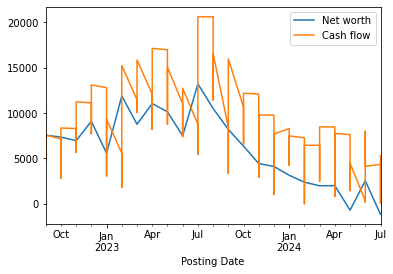

In [105]:
(START_BALANCE + net_worth_df.sum(axis=1).cumsum()).plot()
(START_BALANCE + checking_df.groupby("Posting Date").Amount.sum().cumsum()).plot()
plt.legend(["Net worth", "Cash flow"])